# 3D points to Adjacency matrix

In [4]:
def coordinates_to_adj_mat(ogdata):

  data = ogdata.drop(['Point', 'Cluster'], axis = 1)

  number_of_points = data.shape[0]

  adjacency_matrix = np.zeros((number_of_points, number_of_points))

  for point_A_index, point_A_data in data.iterrows():
    remaining_df = data.loc[point_A_index + 1:]
    for point_B_index, point_B_data in remaining_df.iterrows():
      adjacency_matrix[point_A_index][point_B_index] = np.linalg.norm(point_A_data - point_B_data)
      adjacency_matrix[point_B_index][point_A_index] = adjacency_matrix[point_A_index][point_B_index]

  return adjacency_matrix

In [5]:
# MST
def adj_mat_to_mst(adj_mat):
  mst = []
  from scipy.sparse.csgraph import minimum_spanning_tree
  tree_array = minimum_spanning_tree(adj_mat).toarray()
  number_of_points = tree_array.shape[0]
  for row_index in range(number_of_points):
    for column_index in range(number_of_points):
      if tree_array[row_index][column_index]:
        mst.append({'dist': tree_array[row_index][column_index], 'point_U': row_index, 'point_V': column_index})
  return sorted(mst, key = lambda edge: edge['dist'])

In [6]:
class cluster:
  def __init__(self, ID, reduce_to_dim):
    self.ID = [ID]
    self.points = np.array([[0]*reduce_to_dim])
    self.n_dim = reduce_to_dim
  def translate(self, translation_distance):
    self.points = self.points - translation_distance
  def get_points(self):
    return self.points
  def find_centroid(self):
    return np.mean(self.points, axis = 0)
  def combine_cluster(self, other_cluster, edge_length, reduce_to_dim):
    difference = np.full(reduce_to_dim, edge_length / math.sqrt(reduce_to_dim))
    new_centroid = self.find_centroid() + difference
    translation_distance = other_cluster.find_centroid() - new_centroid
    other_cluster.translate(translation_distance)
    self.points = np.append(self.points, other_cluster.points, axis = 0)
    self.ID.extend(other_cluster.ID)
    del other_cluster

In [7]:
def find_set(set_dict, value):
  for key, current_set in set_dict.items():
    if value in current_set:
      return key

In [8]:
def mst_to_clusters(data, mst, reduce_to_dim):
  set_dict = {}
  cluster_dict = {}

  for index, row in data.iterrows():
    set_dict[index] = {index}
    cluster_dict[index] = cluster(index, reduce_to_dim)

  for edge in mst:
    key_U = find_set(set_dict, edge['point_U'])
    key_V = find_set(set_dict, edge['point_V'])
    set_dict[key_U] = set_dict[key_U].union(set_dict[key_V])
    other_cluster = cluster_dict[key_V]
    edge_length = edge['dist']
    cluster_dict[key_U].combine_cluster(other_cluster, edge_length, reduce_to_dim)
    del set_dict[key_V]
    del cluster_dict[key_V]

  return cluster_dict

In [9]:
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [10]:
def modified_topomap(coordinates, data_name, reduce_to_dim):

  adj_mat = coordinates_to_adj_mat(coordinates)

  mst = adj_mat_to_mst(adj_mat)

  output = mst_to_clusters(coordinates, mst, reduce_to_dim)

  output_df = pd.DataFrame(list(output.values())[0].points, columns=['X'])

  output_df['Point'] = list(output.values())[0].ID

  output_df['Cluster'] = coordinates['Cluster']

  fig=alt.Chart(output_df).mark_point(filled=True).encode(
           x = 'X',
           color=alt.Color('Cluster'),
           tooltip = [alt.Tooltip('Cluster')
              ]).interactive()
  #fig.save('iris_2.html')
  #fig.write_html('{}.html'.format(data_name))
  fig.save('{}.html'.format(data_name))

  fig_2=sns.stripplot(data=output_df,
              x='Cluster',
              y='X',
              jitter=True);
            
  #plot.save('jitter{}.html'.format(data_name))
  fig_2.figure.savefig("{}.png".format(data_name))

Time for iris is: 3.039031744003296
Time for heart is: 126.57610726356506
Time for seeds_dataset is: 5.497743606567383
Time for cancer is: 41.1944522857666
Time for mfeat is: 510.0490913391113


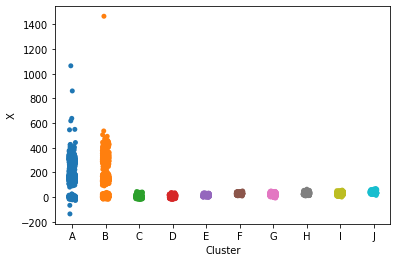

In [11]:
import pandas as pd
import numpy as np
import math
import plotly.express as px
import time

data_list = ['iris','heart', 'seeds_dataset','cancer','mfeat']

reduce_to_dim = 1

for data_name in data_list:
  coordinates = pd.read_csv('{}.csv'.format(data_name))
  start_time = time.time()
  modified_topomap(coordinates, data_name, reduce_to_dim)
  end_time = time.time()
  print('Time for {} is: {}'.format(data_name, end_time - start_time))

In [12]:
# # Visualisation 
# [
#   {
#       dist: 1,
#       point_A: A,
#       point_B: B
#       }
# ]

## Procedure Modified TopoMap
Require: High dimensional points P = {p_1 , p_2, . . . , p_n }

1: Compute the Euclidean minimum spanning tree E_{mst} over P

2: Let E_{mst} = {e_1 , e_2 , . . . , e_{n−1} } be the edges ordered on length

3: Let P′ = {p′_1, p′_2 , . . . , p′_n }, where p′_i = (0, 0), ∀i

4: Let C_i = {p′_i } be the initial set of components, and centroid_i = p'_i be the initial centroid of cluster C_i.

5: **for** each i ∈ [1, n − 1] do

6:&emsp;&emsp; Let (p_a , p_b ) be the end points of edge e_i

7:&emsp;&emsp; Let C_a be the component containing p′_a and C_b be the component containing p′_b

8:&emsp;&emsp; Place C_a and C_b in R^2 s.t. {d(centroid_a , centroid_b )} = length(ei)

9:&emsp;&emsp; Let C_ab = C_a⋃C_b, and compute the centroid of C_ab as centroid_ab

10:&emsp;&emsp; Remove C_a and C_b from the set of components, and add C_ab into this set

11: end **for**

12: return P′